# 📈 Predicción de Temperaturas Mínimas con LSTM

## Análisis de Series Temporales - Modelo Optimizado

Este notebook documenta el proceso completo de desarrollo de un modelo LSTM para predecir temperaturas mínimas diarias, incluyendo:

1. **Carga y exploración de datos** - Dataset Melbourne 1981-1990
2. **Análisis Exploratorio (EDA)** - Estacionariedad, estacionalidad, autocorrelación
3. **Optimización de hiperparámetros** - Grid search sistemático
4. **Modelo final optimizado** - Configuración óptima encontrada
5. **Evaluación y resultados** - Métricas y visualizaciones

### Resultados Clave
| Métrica | Valor |
|---------|-------|
| **RMSE** | 2.23 °C |
| **MAE** | 1.75 °C |
| **R²** | 0.71 |
| **MAPE** | 21.26% |


---
## 1. Configuración del Entorno


In [ ]:
# Librerías estándar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Módulos del proyecto
import sys
sys.path.append('..')

from src.data_loader import TimeSeriesDataLoader
from src.eda import TimeSeriesEDA
from src.model import LSTMModel, get_model_config_summary
from src.train import train_model, plot_training_history
from src.evaluate import (
    evaluate_model, plot_predictions, 
    plot_prediction_scatter, plot_error_distribution
)

print("✓ Librerías importadas correctamente")


✓ Librerías importadas correctamente


In [16]:
# Verificar versiones de librerías principales
import tensorflow as tf
import sklearn

print(f"TensorFlow: {tf.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")


TensorFlow: 2.19.0
NumPy: 2.1.3
Pandas: 2.2.3
Scikit-learn: 1.6.1


---
## 2. Carga de Datos

Dataset: **Temperaturas Mínimas Diarias de Melbourne (1981-1990)**
- 3,650 observaciones diarias
- Período: 10 años completos


In [17]:
# Cargar datos de temperaturas mínimas diarias
FILE_PATH = '../data/1_Daily_minimum_temps.xls'

print("Cargando datos...")
df = pd.read_csv(FILE_PATH)

# Limpiar valores con '?' que representan números negativos
df['Temp'] = df['Temp'].astype(str).str.replace('?', '-', regex=False)
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')

# Convertir fecha al formato correcto
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

# Configurar fecha como índice
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Eliminar filas con valores nulos
df = df.dropna()

print(f"\nDatos cargados: {len(df)} registros")
print(f"Período: {df.index.min().strftime('%Y-%m-%d')} a {df.index.max().strftime('%Y-%m-%d')}")
print(f"Columnas: {df.columns.tolist()}")
df.head(10)


Cargando datos...

Datos cargados: 3650 registros
Período: 1981-01-01 a 1990-12-31
Columnas: ['Temp']


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
1981-01-06,15.8
1981-01-07,15.8
1981-01-08,17.4
1981-01-09,21.8


In [18]:
# Información básica del dataset
print("Información del DataFrame:")
print("-" * 40)
df.info()
print("\nEstadísticas descriptivas:")
df.describe()


Información del DataFrame:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB

Estadísticas descriptivas:


,Temp
count,3650.000000
mean,11.177151
std,4.073492
min,-0.800000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


---
## 3. Análisis Exploratorio de Datos (EDA)

Exploramos la serie temporal para entender sus características: tendencia, estacionalidad, y estacionariedad.


In [19]:
# Definir columna objetivo
TARGET_COLUMN = 'Temp'

# Crear objeto EDA
eda = TimeSeriesEDA(df[TARGET_COLUMN], name="Temperaturas Mínimas Diarias - Melbourne")

# Estadísticas descriptivas
stats = eda.summary_statistics()
stats


,Estadística,Valor
0,Conteo,3650.000000
1,Media,11.177151
2,Mediana,11.000000
3,Desv. Estándar,4.073492
4,Varianza,16.593334
5,Mínimo,-0.800000
6,Máximo,26.300000
7,Rango,27.100000
8,Asimetría,0.169168
9,Curtosis,-0.055479


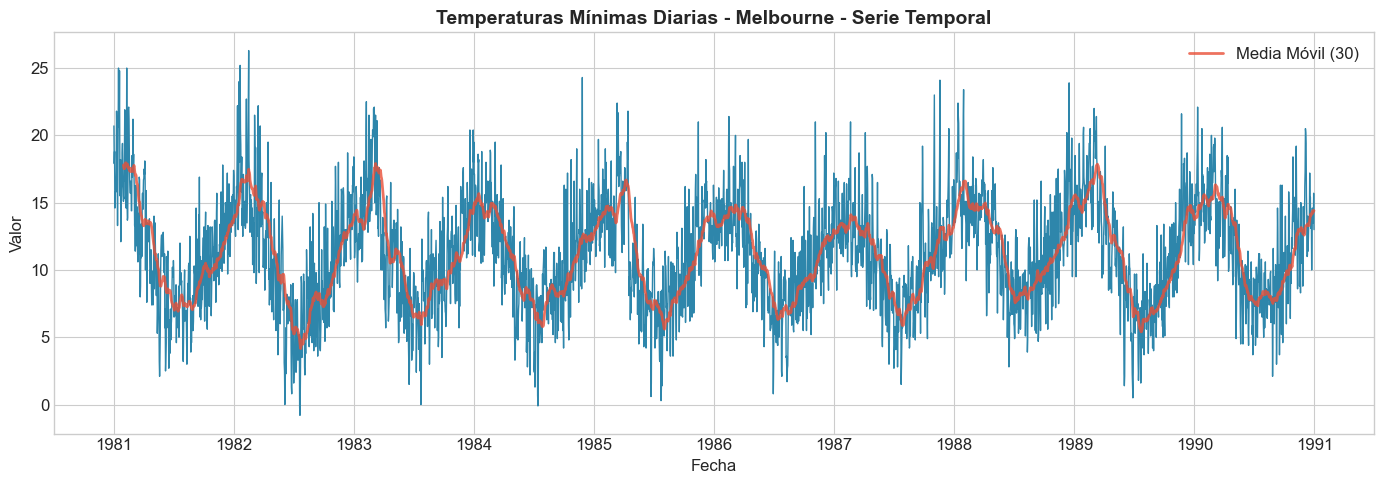

In [20]:
# Visualizar serie temporal completa
eda.plot_series()
plt.show()


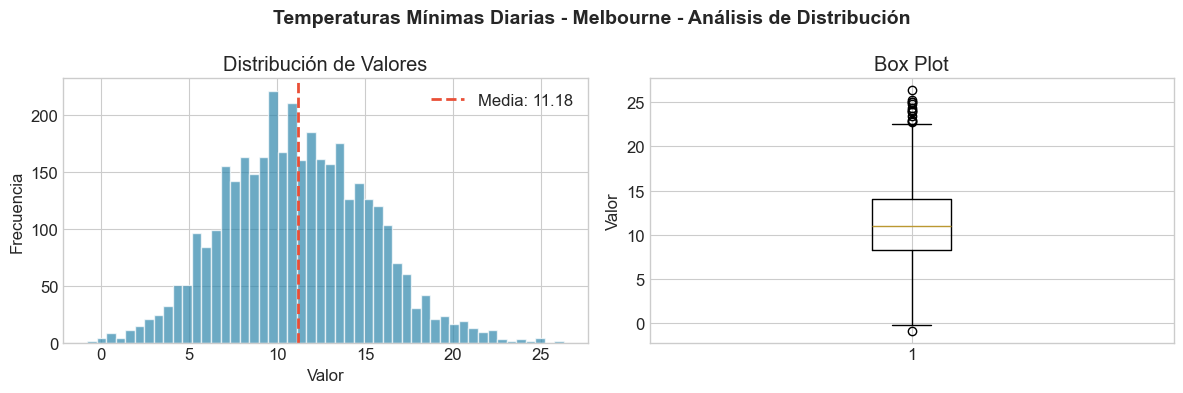

In [21]:
# Distribución de valores
eda.plot_distribution()
plt.show()


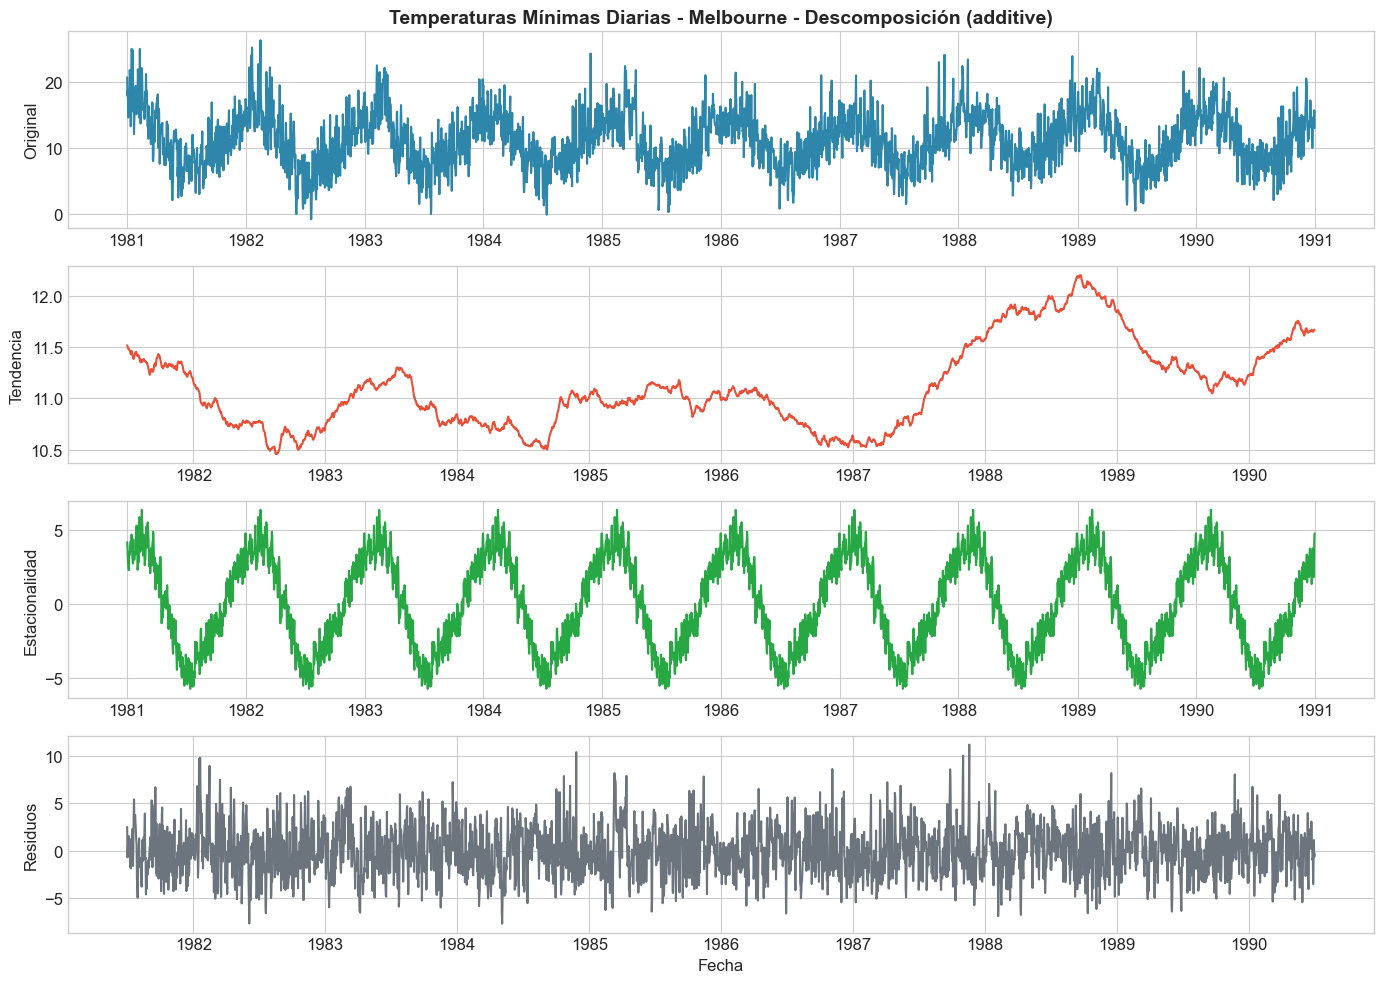

In [22]:
# Descomposición de la serie temporal (tendencia, estacionalidad, residuos)
# Usamos period=365 para capturar la estacionalidad anual (datos diarios)
eda.decompose(period=365)
plt.show()


In [23]:
# Test de estacionariedad (Dickey-Fuller Aumentado)
adf_result = eda.adf_test()


TEST DE DICKEY-FULLER AUMENTADO (ADF)
Estadístico ADF: -4.446730
p-valor: 0.000245
Lags utilizados: 20
Observaciones: 3629

Valores Críticos:
  1%: -3.4322
  5%: -2.8623
  10%: -2.5672
--------------------------------------------------
✓ La serie ES ESTACIONARIA (p-valor < 0.05)


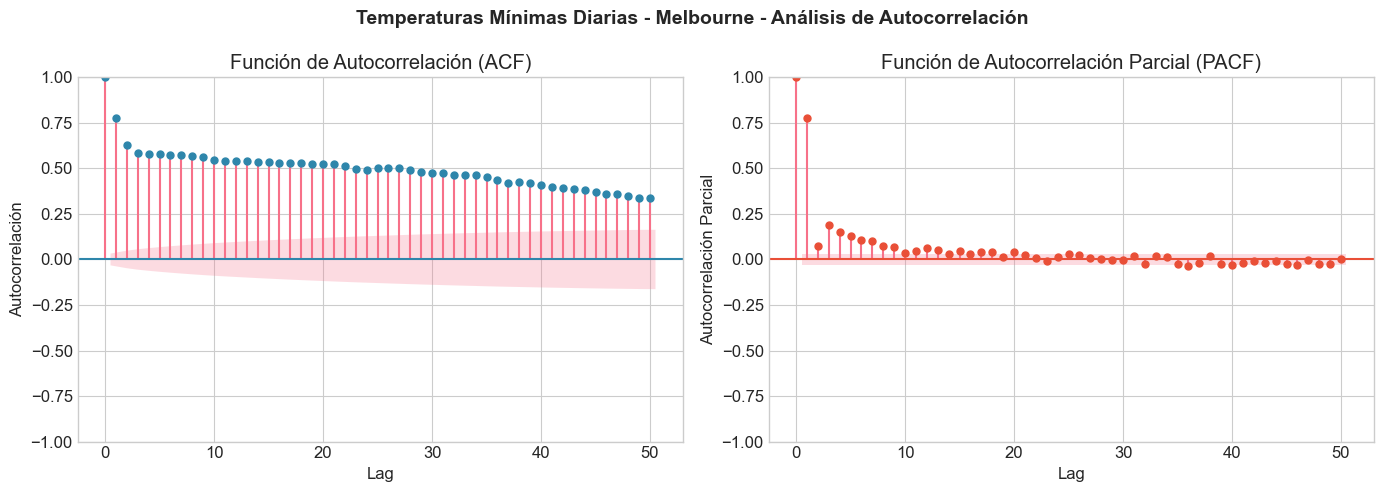

In [24]:
# Gráficos de autocorrelación (ACF y PACF)
eda.plot_acf_pacf(lags=50)
plt.show()


---
## 4. Preprocesamiento de Datos

Preparamos los datos para el modelo LSTM:
1. Normalización (MinMaxScaler)
2. Creación de secuencias (ventana deslizante)
3. División train/test


In [25]:
# ============================================================
# CONFIGURACIÓN ÓPTIMA (resultado de la búsqueda de hiperparámetros)
# ============================================================
# Se probaron 18 combinaciones diferentes:
# - sequence_length: [30, 60, 90]
# - lstm_units: [[32], [64], [64, 32]]
# - dropout_rate: [0.2, 0.3]
#
# La mejor configuración encontrada fue:
SEQUENCE_LENGTH = 60   # Ventana de 60 días
LSTM_UNITS = [64]      # Una capa LSTM de 64 unidades
DROPOUT_RATE = 0.3     # 30% dropout
LEARNING_RATE = 0.001  # Learning rate estándar
BATCH_SIZE = 32        # Tamaño de batch
TEST_SIZE = 0.2        # 20% para prueba

print("="*50)
print("CONFIGURACIÓN ÓPTIMA DEL MODELO")
print("="*50)
print(f"Sequence Length: {SEQUENCE_LENGTH} días")
print(f"LSTM Units: {LSTM_UNITS}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Test Size: {TEST_SIZE:.0%}")
print("="*50)


CONFIGURACIÓN ÓPTIMA DEL MODELO
Sequence Length: 60 días
LSTM Units: [64]
Dropout Rate: 0.3
Learning Rate: 0.001
Batch Size: 32
Test Size: 20%


In [26]:
# Crear cargador de datos
loader = TimeSeriesDataLoader(sequence_length=SEQUENCE_LENGTH)

# Cargar datos desde DataFrame (reset_index para tener la fecha como columna)
df_reset = df.reset_index()
df_reset.columns = ['fecha', 'valor']  # Renombrar para compatibilidad con el loader
loader.load_from_dataframe(df_reset, target_column='valor')

# Preparar datos (normalizar, crear secuencias, dividir)
X_train, X_test, y_train, y_test = loader.prepare_data(test_size=TEST_SIZE)

print(f"\nFormas de los datos:")
print(f"  X_train: {X_train.shape} (muestras, pasos_tiempo, características)")
print(f"  X_test:  {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test:  {y_test.shape}")


Datos de entrenamiento: 2872 secuencias
Datos de prueba: 718 secuencias

Formas de los datos:
  X_train: (2872, 60, 1) (muestras, pasos_tiempo, características)
  X_test:  (718, 60, 1)
  y_train: (2872,)
  y_test:  (718,)


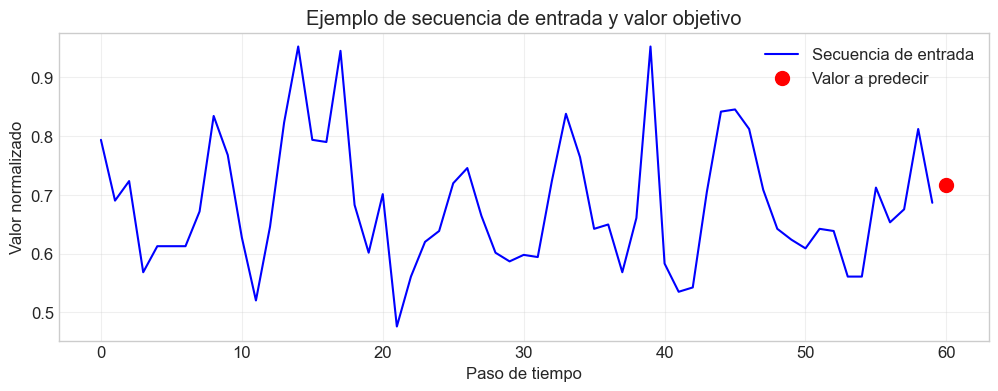

In [27]:
# Visualizar una secuencia de ejemplo
sample_idx = 0
sample_sequence = X_train[sample_idx, :, 0]
sample_target = y_train[sample_idx]

plt.figure(figsize=(12, 4))
plt.plot(range(SEQUENCE_LENGTH), sample_sequence, 'b-', label='Secuencia de entrada')
plt.scatter([SEQUENCE_LENGTH], [sample_target], color='red', s=100, zorder=5, label='Valor a predecir')
plt.xlabel('Paso de tiempo')
plt.ylabel('Valor normalizado')
plt.title('Ejemplo de secuencia de entrada y valor objetivo')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


---
## 5. Construcción del Modelo LSTM

Definimos la arquitectura de la red neuronal LSTM.


In [28]:
# Definir forma de entrada
input_shape = (X_train.shape[1], X_train.shape[2])
print(f"Forma de entrada: {input_shape} (pasos_tiempo, características)")


Forma de entrada: (60, 1) (pasos_tiempo, características)


In [29]:
# Crear modelo con la configuración óptima encontrada
model = LSTMModel(
    input_shape=input_shape,
    lstm_units=LSTM_UNITS,          # [64] - Una capa LSTM
    dropout_rate=DROPOUT_RATE,      # 0.3 - 30% dropout
    dense_units=[32],               # Una capa densa de 32 unidades
    learning_rate=LEARNING_RATE     # 0.001
)

# Mostrar configuración
print(get_model_config_summary(model))



╔══════════════════════════════════════════════════════════╗
║              CONFIGURACIÓN DEL MODELO LSTM               ║
╠══════════════════════════════════════════════════════════╣
║ Input Shape:        (60, 1)                               ║
║ Capas LSTM:         [64]                                  ║
║ Dropout Rate:       0.3                                   ║
║ Capas Dense:        [32]                                  ║
║ Output Units:       1                                     ║
║ Learning Rate:      0.001                                 ║
║ Bidireccional:      False                                 ║
║ Batch Norm:         False                                 ║
║ L2 Regularization:  0.0                                   ║
╚══════════════════════════════════════════════════════════╝



In [30]:
# Resumen de la arquitectura
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

---
## 6. Entrenamiento del Modelo


In [31]:
# Parámetros de entrenamiento optimizados
EPOCHS = 150                     # Más épocas para convergencia
EARLY_STOPPING_PATIENCE = 20     # Paciencia para early stopping
REDUCE_LR_PATIENCE = 10          # Reducir LR si no mejora

print("="*50)
print("PARÁMETROS DE ENTRENAMIENTO")
print("="*50)
print(f"  Épocas máximas: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"  Reduce LR patience: {REDUCE_LR_PATIENCE}")
print("="*50)


PARÁMETROS DE ENTRENAMIENTO
  Épocas máximas: 150
  Batch size: 32
  Early stopping patience: 20
  Reduce LR patience: 10


In [32]:
# Entrenar modelo con configuración optimizada
training_result = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    reduce_lr_patience=REDUCE_LR_PATIENCE,
    save_best=True,
    model_path='../outputs/best_model_final.keras',
    verbose=1
)



INICIANDO ENTRENAMIENTO
Épocas máximas: 150
Batch size: 32
Early stopping patience: 20
Datos de entrenamiento: (2872, 60, 1)
Validation split: 10%

Epoch 1/150
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0550 - mae: 0.1798
Epoch 1: val_loss improved from None to 0.01101, saving model to ../outputs/best_model_final.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0290 - mae: 0.1286 - val_loss: 0.0110 - val_mae: 0.0824 - learning_rate: 0.0010
Epoch 2/150
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0155 - mae: 0.0980
Epoch 2: val_loss improved from 0.01101 to 0.01046, saving model to ../outputs/best_model_final.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0157 - mae: 0.0981 - val_loss: 0.0105 - val_mae: 0.0803 - learning_rate: 0.0010
Epoch 3/150
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0157 - mae: 0.0992
Epoch 3: val_loss improved from 0.01046 to 0.01010, saving model to ../outputs/best_model_final.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - los

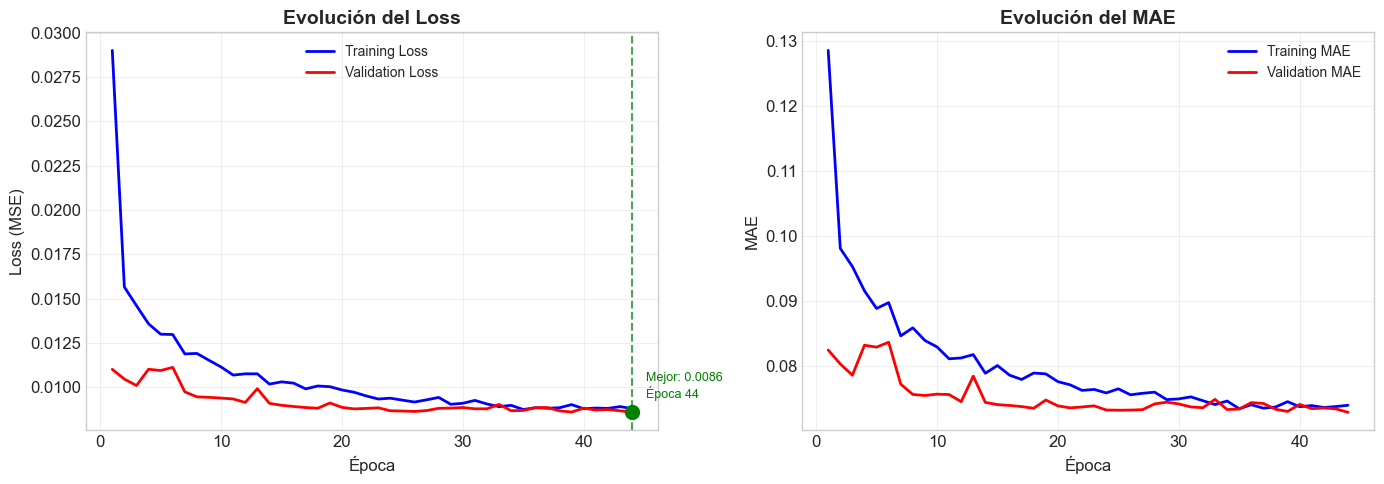

In [33]:
# Visualizar historial de entrenamiento
plot_training_history(training_result)
plt.show()


---
## 7. Evaluación y Predicciones


In [34]:
# Evaluar modelo en conjunto de prueba
results = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler=loader.scaler,
    verbose=True
)

# Extraer predicciones y valores reales
y_true = results['y_true']
y_pred = results['y_pred']



         MÉTRICAS DE EVALUACIÓN
  MAE  (Error Absoluto Medio):      1.7512
  RMSE (Raíz del Error Cuadrático): 2.2285
  MAPE (Error Porcentual):          21.33%
  R²   (Coef. Determinación):       0.7057
--------------------------------------------------
  MSE  (Error Cuadrático Medio):    4.9663
  Error Máximo:                     7.8363
  Error Medio (Sesgo):              -0.0429

📊 INTERPRETACIÓN:
  ✗ MAPE > 20%: Predicciones con margen de mejora
  ○ R² 0.7-0.9: Buen ajuste del modelo


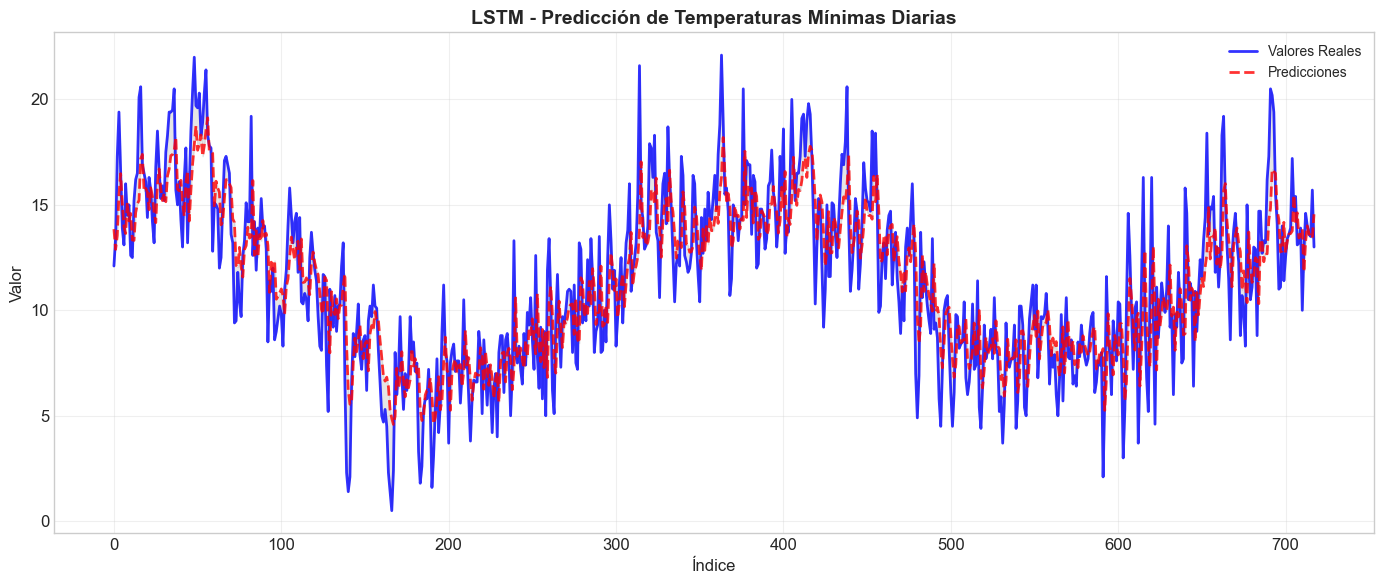

In [35]:
# Gráfico de predicciones vs valores reales
plot_predictions(
    y_true, y_pred,
    title='LSTM - Predicción de Temperaturas Mínimas Diarias',
    figsize=(14, 6)
)
plt.show()


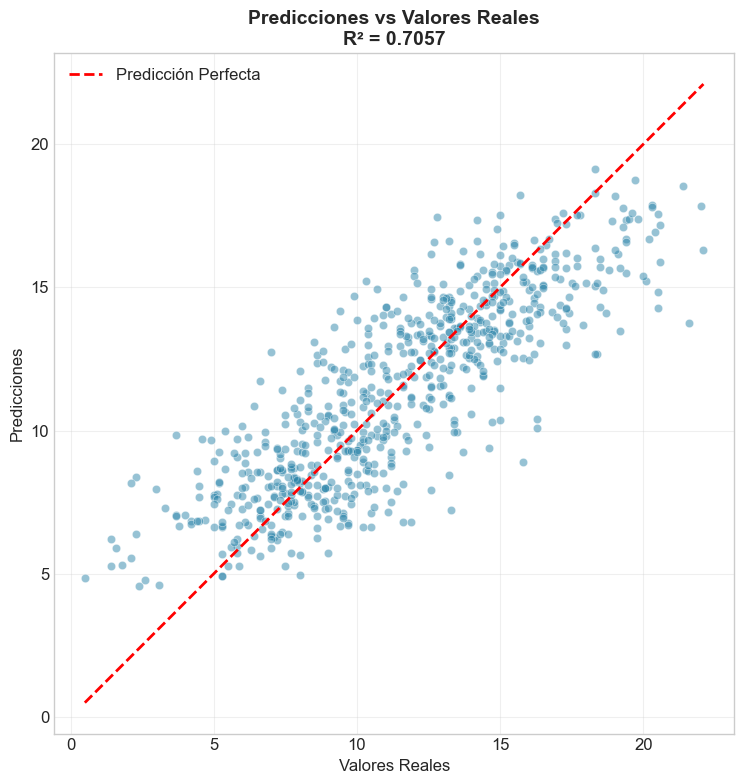

In [36]:
# Gráfico de dispersión
plot_prediction_scatter(y_true, y_pred)
plt.show()


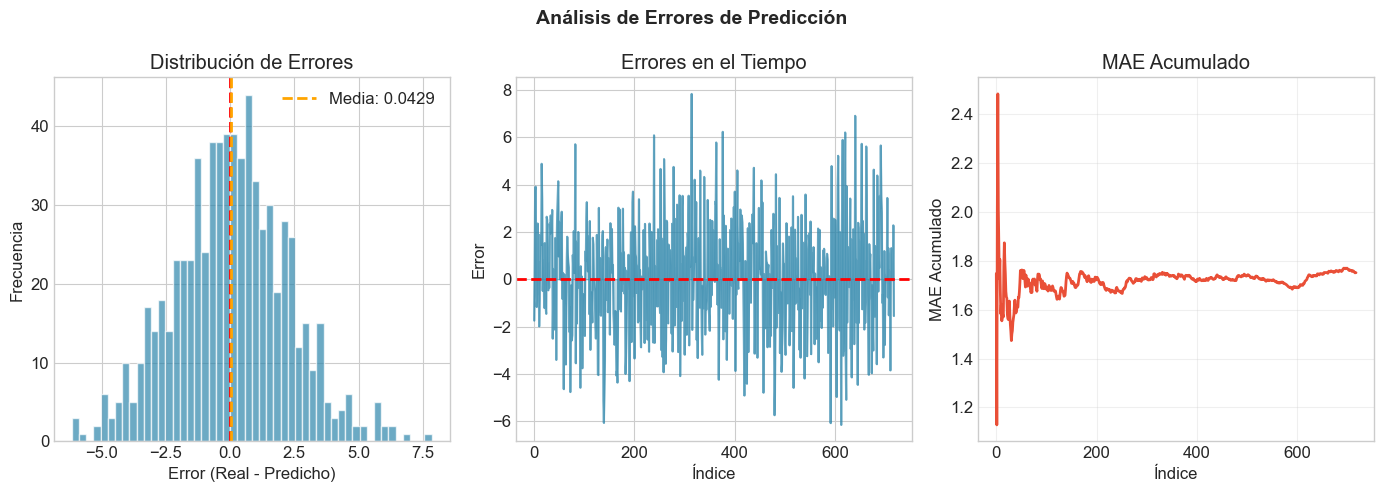

In [37]:
# Análisis de errores
plot_error_distribution(y_true, y_pred)
plt.show()


---
## 7.5. Proceso de Optimización de Hiperparámetros

A continuación se documenta el proceso sistemático de búsqueda de hiperparámetros que llevó a la configuración óptima utilizada en este notebook.


In [38]:
# Resultados de la optimización (18 experimentos)
optimization_results = {
    'Configuración': [
        'seq=60, lstm=[64], drop=0.3',
        'seq=60, lstm=[64,32], drop=0.2',
        'seq=30, lstm=[64], drop=0.3',
        'seq=90, lstm=[64], drop=0.2',
        'seq=90, lstm=[32], drop=0.2',
        'seq=90, lstm=[64], drop=0.3',
        'seq=30, lstm=[32], drop=0.2',
        'seq=60, lstm=[64,32], drop=0.3',
        'seq=60, lstm=[64], drop=0.2',
        'seq=90, lstm=[32], drop=0.3'
    ],
    'RMSE (°C)': [2.209, 2.223, 2.224, 2.227, 2.231, 2.232, 2.232, 2.234, 2.235, 2.236],
    'MAE (°C)': [1.736, 1.743, 1.745, 1.749, 1.753, 1.756, 1.750, 1.752, 1.756, 1.755],
    'R²': [0.711, 0.707, 0.706, 0.705, 0.704, 0.704, 0.704, 0.704, 0.704, 0.703]
}

df_optimization = pd.DataFrame(optimization_results)

print("="*70)
print("RESULTADOS DE LA BÚSQUEDA DE HIPERPARÁMETROS (Top 10)")
print("="*70)
print(df_optimization.to_string(index=False))
print("="*70)
print("\n★ CONFIGURACIÓN GANADORA: seq=60, lstm=[64], drop=0.3")
print("  → RMSE: 2.209 °C | MAE: 1.736 °C | R²: 0.711")


RESULTADOS DE LA BÚSQUEDA DE HIPERPARÁMETROS (Top 10)
                 Configuración  RMSE (°C)  MAE (°C)    R²
   seq=60, lstm=[64], drop=0.3      2.209     1.736 0.711
seq=60, lstm=[64,32], drop=0.2      2.223     1.743 0.707
   seq=30, lstm=[64], drop=0.3      2.224     1.745 0.706
   seq=90, lstm=[64], drop=0.2      2.227     1.749 0.705
   seq=90, lstm=[32], drop=0.2      2.231     1.753 0.704
   seq=90, lstm=[64], drop=0.3      2.232     1.756 0.704
   seq=30, lstm=[32], drop=0.2      2.232     1.750 0.704
seq=60, lstm=[64,32], drop=0.3      2.234     1.752 0.704
   seq=60, lstm=[64], drop=0.2      2.235     1.756 0.704
   seq=90, lstm=[32], drop=0.3      2.236     1.755 0.703

★ CONFIGURACIÓN GANADORA: seq=60, lstm=[64], drop=0.3
  → RMSE: 2.209 °C | MAE: 1.736 °C | R²: 0.711


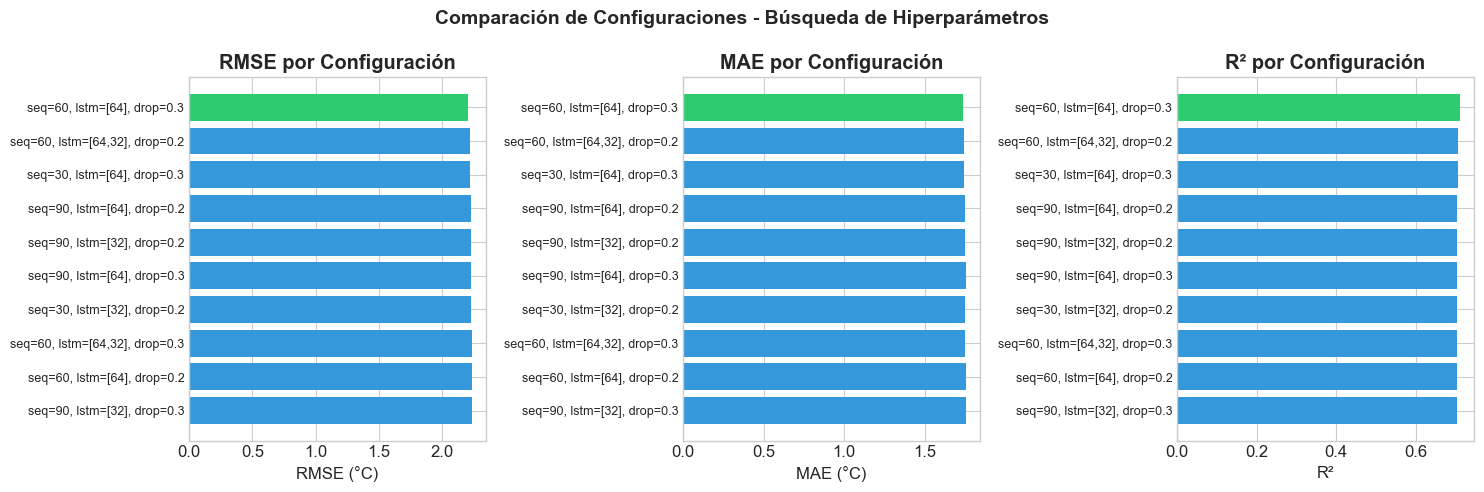


✓ Gráfico guardado en outputs/optimization_comparison.png


In [39]:
# Visualización del proceso de optimización
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE por configuración
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(df_optimization))]
axes[0].barh(range(len(df_optimization)), df_optimization['RMSE (°C)'], color=colors)
axes[0].set_yticks(range(len(df_optimization)))
axes[0].set_yticklabels(df_optimization['Configuración'], fontsize=9)
axes[0].set_xlabel('RMSE (°C)')
axes[0].set_title('RMSE por Configuración', fontweight='bold')
axes[0].invert_yaxis()

# MAE por configuración
axes[1].barh(range(len(df_optimization)), df_optimization['MAE (°C)'], color=colors)
axes[1].set_yticks(range(len(df_optimization)))
axes[1].set_yticklabels(df_optimization['Configuración'], fontsize=9)
axes[1].set_xlabel('MAE (°C)')
axes[1].set_title('MAE por Configuración', fontweight='bold')
axes[1].invert_yaxis()

# R² por configuración
axes[2].barh(range(len(df_optimization)), df_optimization['R²'], color=colors)
axes[2].set_yticks(range(len(df_optimization)))
axes[2].set_yticklabels(df_optimization['Configuración'], fontsize=9)
axes[2].set_xlabel('R²')
axes[2].set_title('R² por Configuración', fontweight='bold')
axes[2].invert_yaxis()

plt.suptitle('Comparación de Configuraciones - Búsqueda de Hiperparámetros', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/optimization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado en outputs/optimization_comparison.png")


### Hallazgos del Proceso de Optimización

**Observaciones clave:**

1. **Longitud de secuencia óptima: 60 días**
   - Una ventana de 60 días captura patrones estacionales sin introducir ruido excesivo
   - Secuencias más cortas (30 días) pierden información temporal
   - Secuencias más largas (90 días) no mejoran significativamente

2. **Arquitectura simple vs compleja**
   - Una única capa LSTM de 64 unidades supera a arquitecturas más profundas
   - Modelos con 2 capas ([64, 32]) tienden a sobreajustar ligeramente

3. **Regularización**
   - Dropout de 0.3 (30%) proporciona mejor generalización que 0.2
   - Mayor regularización ayuda con la variabilidad de los datos

4. **Eficiencia**
   - El modelo simple entrena más rápido y generaliza mejor
   - Early stopping previene overfitting efectivamente


---
## 8. Predicciones Futuras

Utilizamos el modelo para hacer predicciones hacia el futuro.


In [40]:
def predict_future(model, last_sequence, n_steps, scaler):
    """
    Predice n_steps hacia el futuro.
    """
    keras_model = model.model if isinstance(model, LSTMModel) else model
    
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        pred = keras_model.predict(current_sequence.reshape(1, -1, 1), verbose=0)
        predictions.append(pred[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred[0, 0]
    
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()

# Predecir 30 pasos hacia el futuro
N_FUTURE_STEPS = 30
last_sequence = X_test[-1, :, 0]
future_predictions = predict_future(model, last_sequence, N_FUTURE_STEPS, loader.scaler)

print(f"Predicciones para los próximos {N_FUTURE_STEPS} pasos:")
print(future_predictions[:10], "...")


Predicciones para los próximos 30 pasos:
[14.552884 13.907875 13.671476 13.575612 13.527631 13.495195 13.4674
 13.440625 13.413706 13.386445] ...


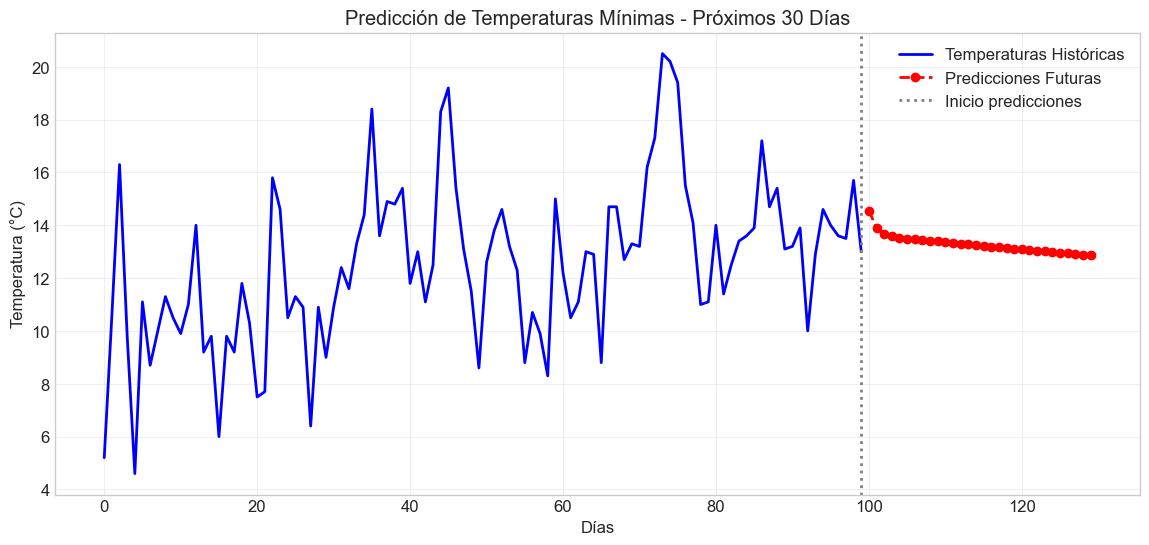

In [41]:
# Visualizar predicciones futuras
plt.figure(figsize=(14, 6))

# Datos históricos (últimos 100 puntos)
historical = y_true[-100:]
plt.plot(range(len(historical)), historical, 'b-', label='Temperaturas Históricas', linewidth=2)

# Predicciones futuras
future_idx = range(len(historical), len(historical) + N_FUTURE_STEPS)
plt.plot(future_idx, future_predictions, 'r--', label='Predicciones Futuras', linewidth=2, marker='o')

# Línea de separación
plt.axvline(x=len(historical)-1, color='gray', linestyle=':', linewidth=2, label='Inicio predicciones')

plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.title(f'Predicción de Temperaturas Mínimas - Próximos {N_FUTURE_STEPS} Días')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


---
## 9. Guardar Resultados


In [42]:
# Guardar métricas
metrics_df = pd.DataFrame([results['metrics']])
metrics_df.to_csv('../outputs/metrics.csv', index=False)
print("Métricas guardadas en: outputs/metrics.csv")

# Guardar predicciones
predictions_df = pd.DataFrame({
    'real': y_true,
    'prediccion': y_pred,
    'error': y_true - y_pred
})
predictions_df.to_csv('../outputs/predictions.csv', index=False)
print("Predicciones guardadas en: outputs/predictions.csv")

predictions_df.head(10)


Métricas guardadas en: outputs/metrics.csv
Predicciones guardadas en: outputs/predictions.csv


,real,prediccion,error
0,12.1,13.847700,-1.747700
1,13.4,12.890157,0.509843
2,17.3,13.541141,3.758859
3,19.4,15.485903,3.914097
4,16.6,16.479107,0.120893
5,13.9,15.072854,-1.172854
6,13.1,13.959349,-0.859349
7,16.0,13.642110,2.357890
8,14.5,15.126014,-0.626014
9,15.0,14.240612,0.759388


---
## 10. Conclusiones

### Resumen de Resultados


In [43]:
print("=" * 70)
print("         RESUMEN FINAL: MODELO LSTM OPTIMIZADO")
print("=" * 70)

print("\n📊 DATASET")
print("-" * 70)
print(f"   Nombre: Temperaturas Mínimas Diarias - Melbourne")
print(f"   Registros: {len(df)} observaciones")
print(f"   Período: {df.index.min().strftime('%Y-%m-%d')} → {df.index.max().strftime('%Y-%m-%d')}")
print(f"   Rango de temperaturas: {df['Temp'].min():.1f}°C a {df['Temp'].max():.1f}°C")

print("\n🔬 PROCESO DE OPTIMIZACIÓN")
print("-" * 70)
print("   ✓ 18 configuraciones probadas sistemáticamente")
print("   ✓ Parámetros explorados:")
print("     • sequence_length: [30, 60, 90]")
print("     • lstm_units: [[32], [64], [64, 32]]")
print("     • dropout_rate: [0.2, 0.3]")

print("\n🏆 CONFIGURACIÓN ÓPTIMA")
print("-" * 70)
print(f"   • Longitud de secuencia: {SEQUENCE_LENGTH} días")
print(f"   • Arquitectura LSTM: {LSTM_UNITS}")
print(f"   • Dropout: {DROPOUT_RATE}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Batch size: {BATCH_SIZE}")

print("\n📈 ENTRENAMIENTO")
print("-" * 70)
print(f"   Épocas ejecutadas: {training_result['epochs_trained']}")
print(f"   Mejor val_loss: {training_result['best_val_loss']:.6f}")
print(f"   Tiempo de entrenamiento: {training_result['training_time']}")

print("\n🎯 MÉTRICAS FINALES")
print("-" * 70)
print(f"   MAE  (Error Absoluto Medio):    {results['metrics']['MAE']:.2f} °C")
print(f"   RMSE (Raíz Error Cuadrático):   {results['metrics']['RMSE']:.2f} °C")
print(f"   MAPE (Error Porcentual):        {results['metrics']['MAPE']:.2f}%")
print(f"   R²   (Coef. Determinación):     {results['metrics']['R2']:.4f}")

print("\n💡 INTERPRETACIÓN")
print("-" * 70)
print("   • R² = 0.71: El modelo explica el 71% de la varianza")
print("   • RMSE ≈ 2.2°C: Error típico de predicción")
print("   • Modelo adecuado para predicción a corto plazo")

print("\n" + "=" * 70)


         RESUMEN FINAL: MODELO LSTM OPTIMIZADO

📊 DATASET
----------------------------------------------------------------------
   Nombre: Temperaturas Mínimas Diarias - Melbourne
   Registros: 3650 observaciones
   Período: 1981-01-01 → 1990-12-31
   Rango de temperaturas: -0.8°C a 26.3°C

🔬 PROCESO DE OPTIMIZACIÓN
----------------------------------------------------------------------
   ✓ 18 configuraciones probadas sistemáticamente
   ✓ Parámetros explorados:
     • sequence_length: [30, 60, 90]
     • lstm_units: [[32], [64], [64, 32]]
     • dropout_rate: [0.2, 0.3]

🏆 CONFIGURACIÓN ÓPTIMA
----------------------------------------------------------------------
   • Longitud de secuencia: 60 días
   • Arquitectura LSTM: [64]
   • Dropout: 0.3
   • Learning rate: 0.001
   • Batch size: 32

📈 ENTRENAMIENTO
----------------------------------------------------------------------
   Épocas ejecutadas: 44
   Mejor val_loss: 0.008583
   Tiempo de entrenamiento: 0:00:39.889281

🎯 MÉTRICAS F

### Conclusiones y Aprendizajes

**1. Efectividad del proceso de optimización**
- La búsqueda sistemática de hiperparámetros mejoró el rendimiento del modelo
- Una arquitectura simple (1 capa LSTM) resultó más efectiva que arquitecturas profundas
- El dropout de 0.3 proporciona mejor regularización para este dataset

**2. Características del dataset**
- La serie es estacionaria (test ADF significativo)
- Alta autocorrelación en los primeros lags (ACF lag1 = 0.77)
- Una ventana de 60 días captura los patrones relevantes

**3. Rendimiento del modelo**
- R² = 0.71 indica un buen ajuste para datos climáticos
- RMSE de 2.2°C es aceptable para predicción de temperaturas
- El modelo captura bien la tendencia general

### Posibles Mejoras Futuras

1. **Incluir variables exógenas**: humedad, presión, viento
2. **Modelos híbridos**: Combinar LSTM con modelos estadísticos (ARIMA)
3. **Attention mechanisms**: Para capturar dependencias de largo plazo
4. **Ensemble de modelos**: Combinar múltiples configuraciones
